In [1]:
using Oceananigans
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using JLD2

[ Info: Oceananigans will use 4 threads


In [95]:
close(file)

In [2]:
filename = "../../scratch/Project/vortex-strain-2/output.jld2"
file = jldopen(filename)

JLDFile /gpfs/fs0/scratch/n/ngrisoua/atkin163/Project/vortex-strain-2/output.jld2 (read-only)
 ├─📂 grid
 │  ├─🔢 Nx
 │  ├─🔢 Ny
 │  ├─🔢 Nz
 │  ├─🔢 Hx
 │  ├─🔢 Hy
 │  ├─🔢 Hz
 │  ├─🔢 Lx
 │  └─ ⋯ (14 more entries)
 └─ ⋯ (4 more entries)

In [3]:
frames = keys(file["timeseries/t"]);
xs = xnodes(file["serialized/grid"], Center());
ys = ynodes(file["serialized/grid"], Center());
zs = znodes(file["serialized/grid"], Center());

In [4]:
f = jldopen("../../scratch/Project/vortex-strain-2/parameters.jld2") do file
    file["f"]
end

0.0001

In [5]:
frames

201-element Vector{String}:
 "0"
 "68"
 "109"
 "139"
 "162"
 "181"
 "198"
 "214"
 "230"
 "247"
 "264"
 "313"
 "404"
 ⋮
 "7346"
 "7411"
 "7504"
 "7585"
 "7663"
 "7737"
 "7814"
 "7889"
 "7969"
 "8061"
 "8152"
 "8232"

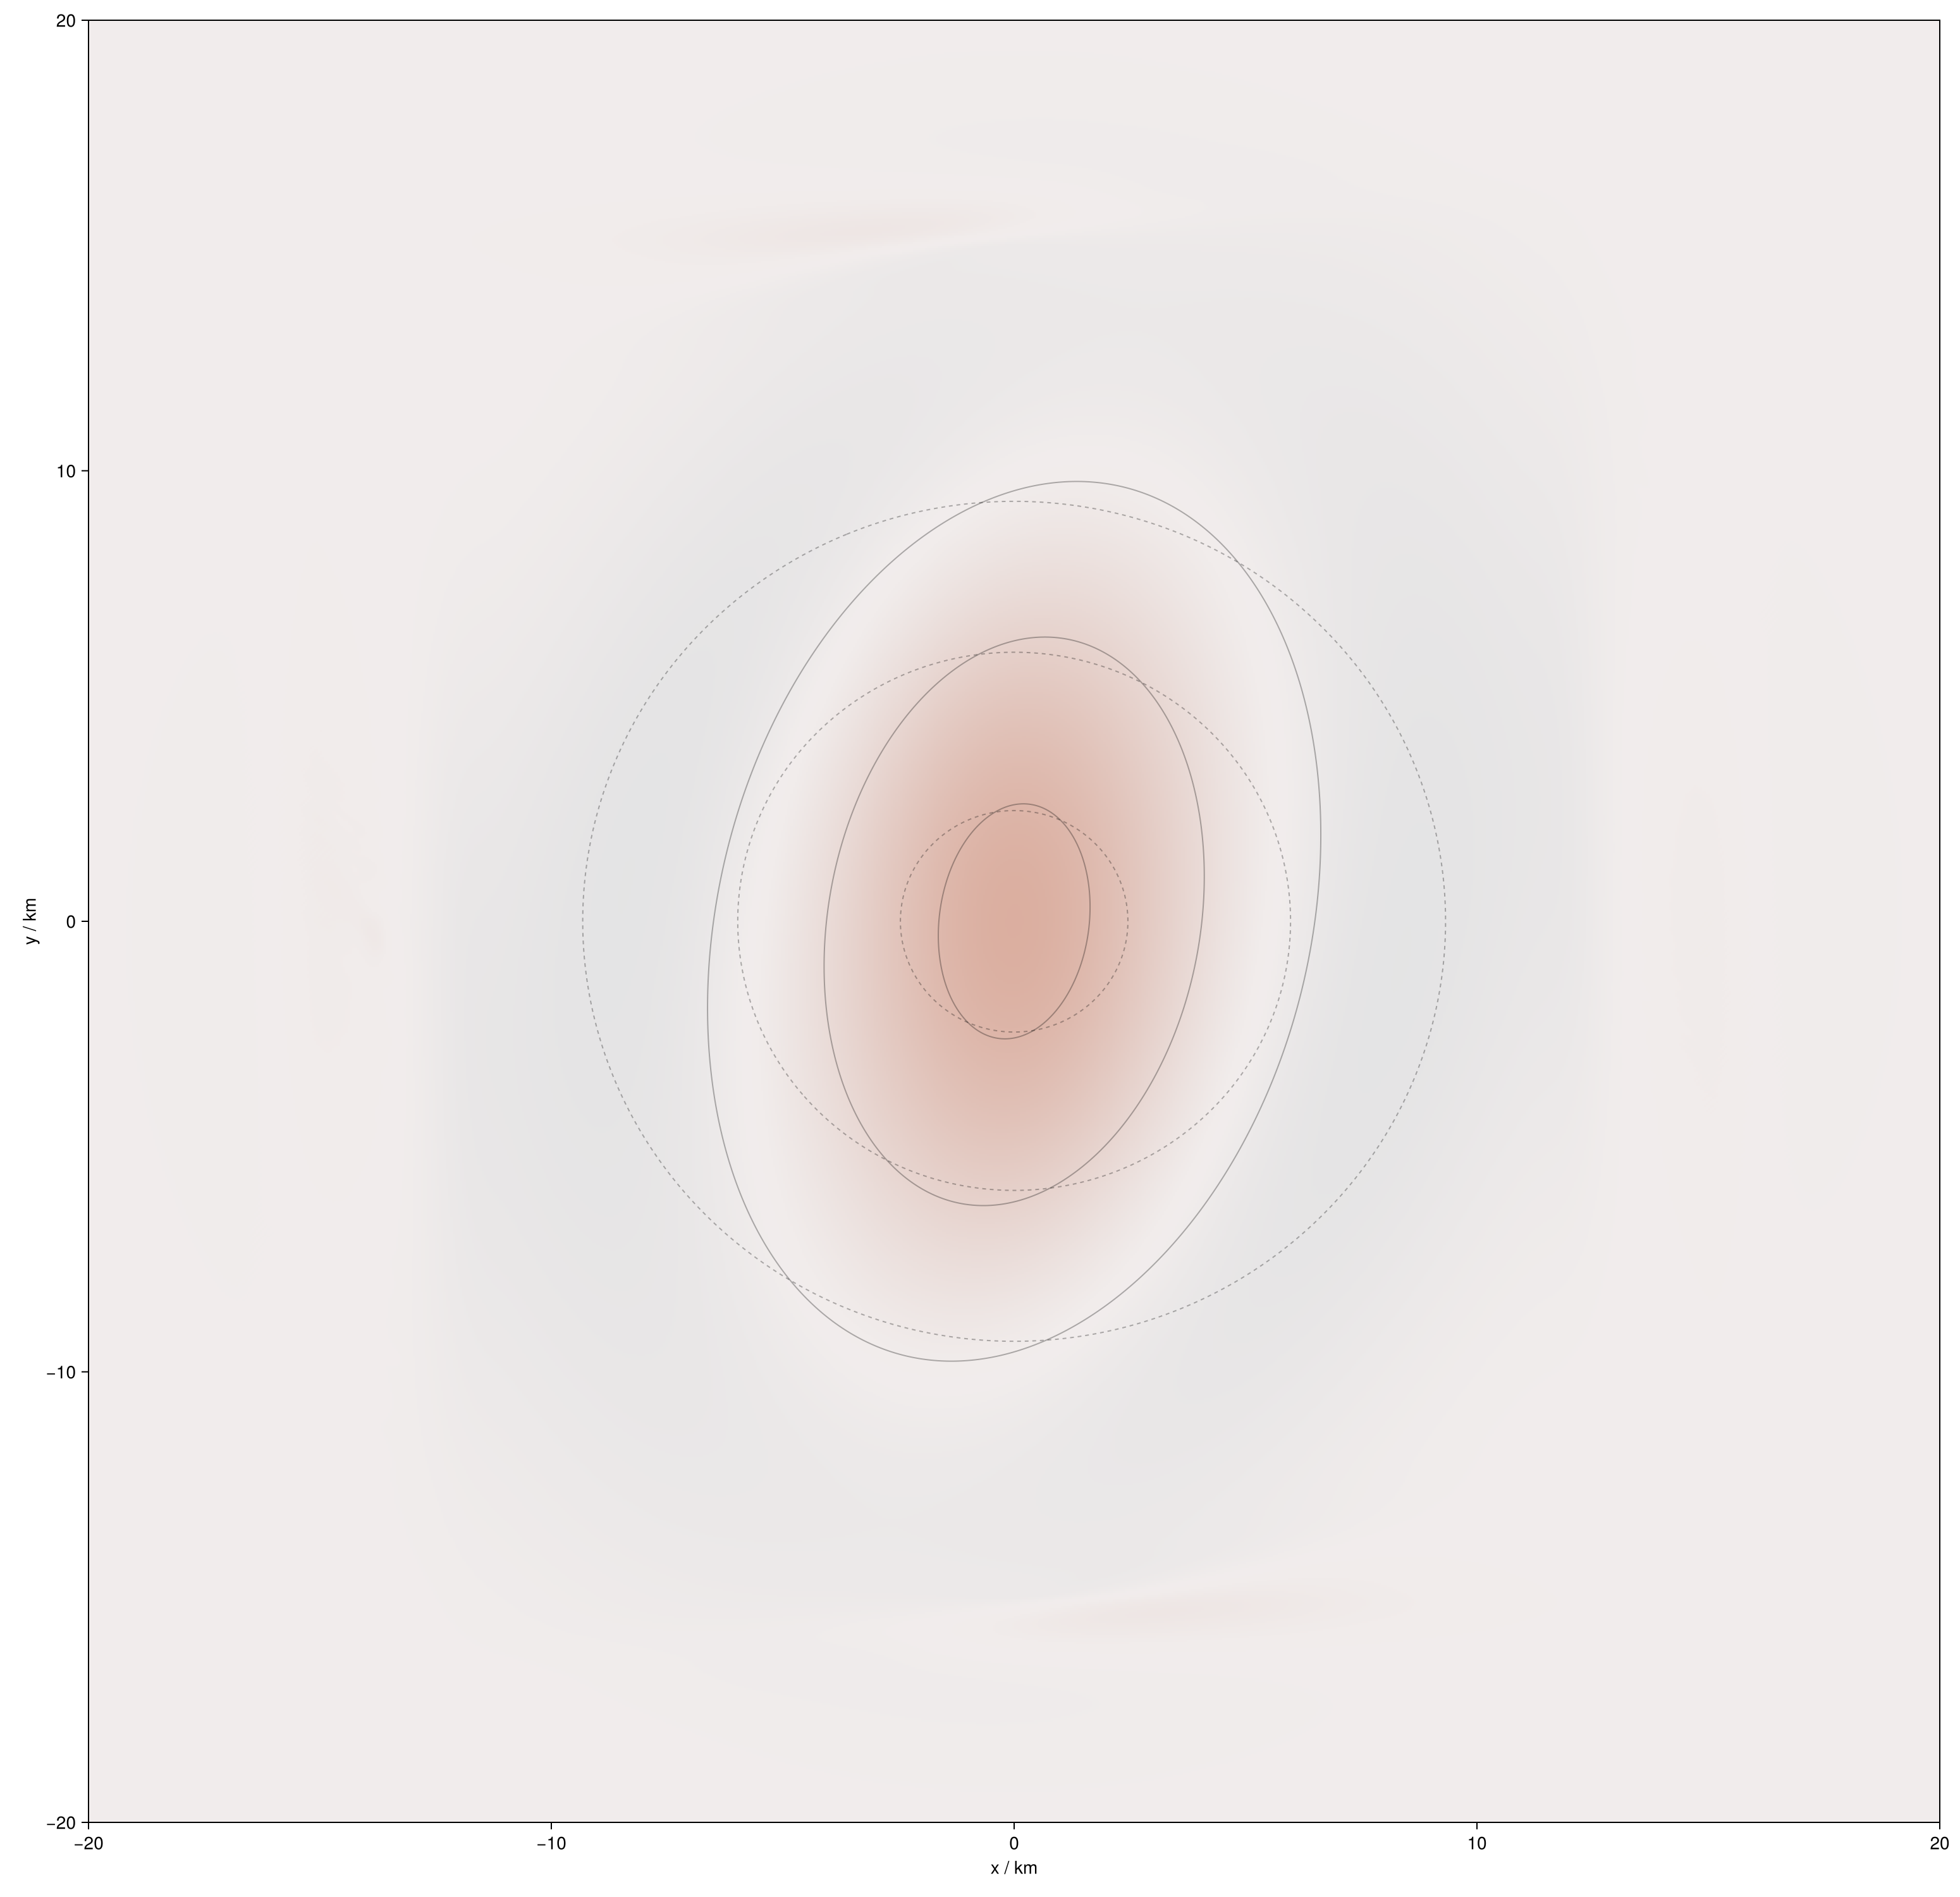

In [20]:
n = 31
fig = Figure(; size=(1550, 1500))
ax = Axis(fig[1, 1]; xlabel="x / km", ylabel="y / km", limits=(-20, 20, -20, 20))
s = sqrt.(file["timeseries/u/$(frames[n])"][1:1000, 1:1000, end].^2 .+ file["timeseries/v/$(frames[n])"][1:1000, 1:1000, end].^2)
ζs(n) = let u = (file["timeseries/u/$(frames[n])"][1:end-1, :, end] .+ file["timeseries/u/$(frames[n])"][2:end, :, end]) ./ 2
    v = (file["timeseries/v/$(frames[n])"][:, 1:end-1, end] .+ file["timeseries/v/$(frames[n])"][:, 2:end, end]) ./ 2
    ∂xv = (circshift(v, (-1, 0)) .- circshift(v, (1, 0))) ./ (xs[3] - xs[1])
    ∂yu = (circshift(u, (0, -1)) .- circshift(u, (0, 1))) ./ (ys[3] - ys[1])
    ∂xv .- ∂yu
end
#w = (file["timeseries/w/$(frames[n])"][1:1000, 1:1000, end] - file["timeseries/w/$(frames[n])"][1:1000, 1:1000, end-1]) ./ (zs[end]-zs[end-1])
#w = imfilter(w, gaussian((3, 3)))
heatmap!(ax, xs./1000, ys./1000, ζs(n); colormap=:balance, colorrange=(-3f, 3f))
contour!(ax, xs./1000, ys./1000, file["timeseries/b/$(frames[n])"][:, :, end]; color=(:black, 0.3), levels=range(-2e-3, 0, 4))
#contour!(ax, xs./1000, ys./1000, ζs(1); colormap=:balance, color=:red, colorrange=(-3f, 3f), levels=[0.3f], linestyle=:dash)
contour!(ax, xs./1000, ys./1000, file["timeseries/b/$(frames[1])"][:, :, end]; color=(:black, 0.3), levels=range(-2e-3, 0, 4), linestyle=:dash)
fig

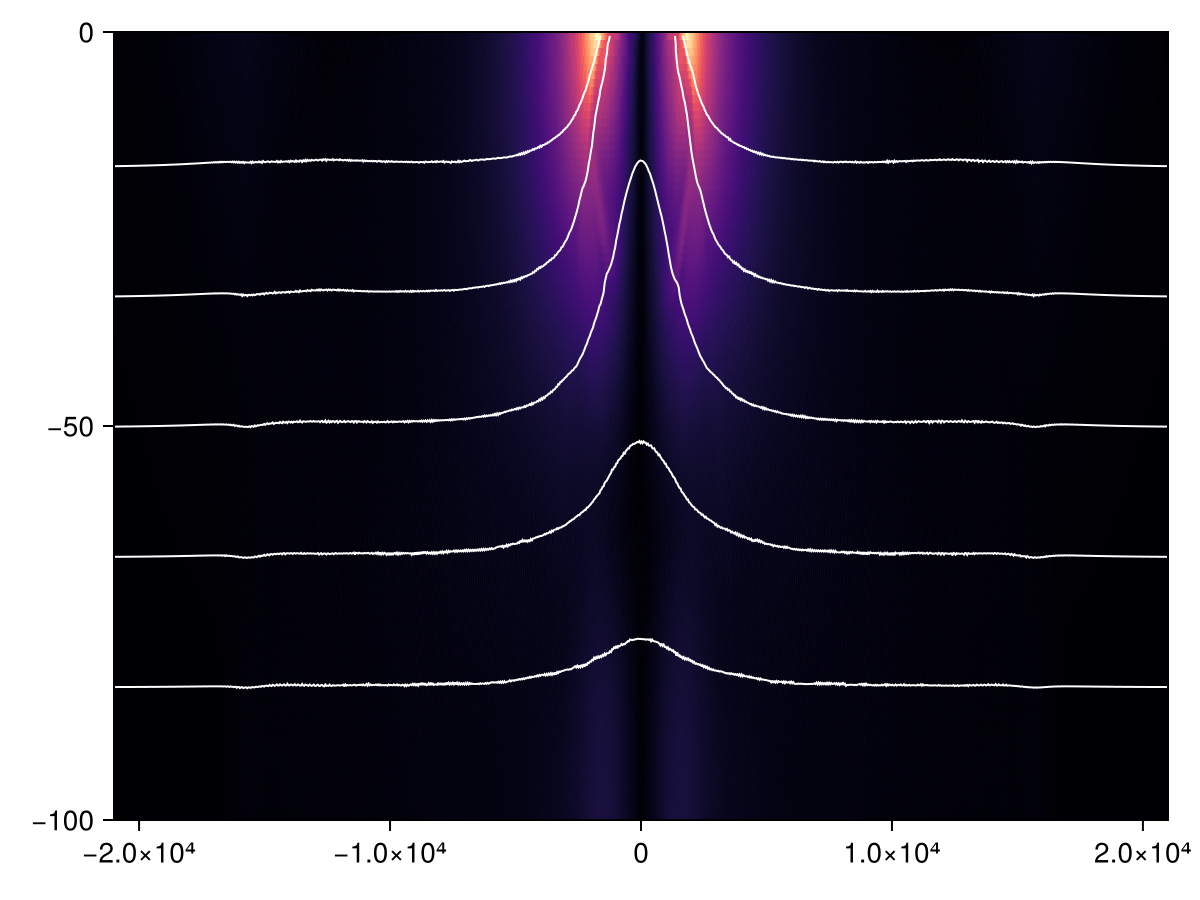

In [6]:
n =  201
fig = Figure()
ax = Axis(fig[1, 1])
s = sqrt.(file["timeseries/u/$(frames[n])"][1:1000, 500, :].^2 .+ file["timeseries/v/$(frames[n])"][1:1000, 500, :].^2)
heatmap!(ax, xs, zs, s; colormap=:magma)
contour!(ax, xs, zs, file["timeseries/b/$(frames[n])"][1:1000, 500, :]; color=:white)
fig

In [68]:
include("../src-vortices/parameters.jl")
include("../src-vortices/base_state.jl")
include("../src-vortices/forcing_functions.jl")

create_forcings (generic function with 1 method)

In [69]:
sp = create_simulation_parameters(; Ro=1, H=100, Ri=1);
base_state = get_base_state(sp)
σ = create_forcings(base_state, sp);

[ Info: Created front state with NaN < Ri, NaN < Ro < NaN


σ (generic function with 1 method)

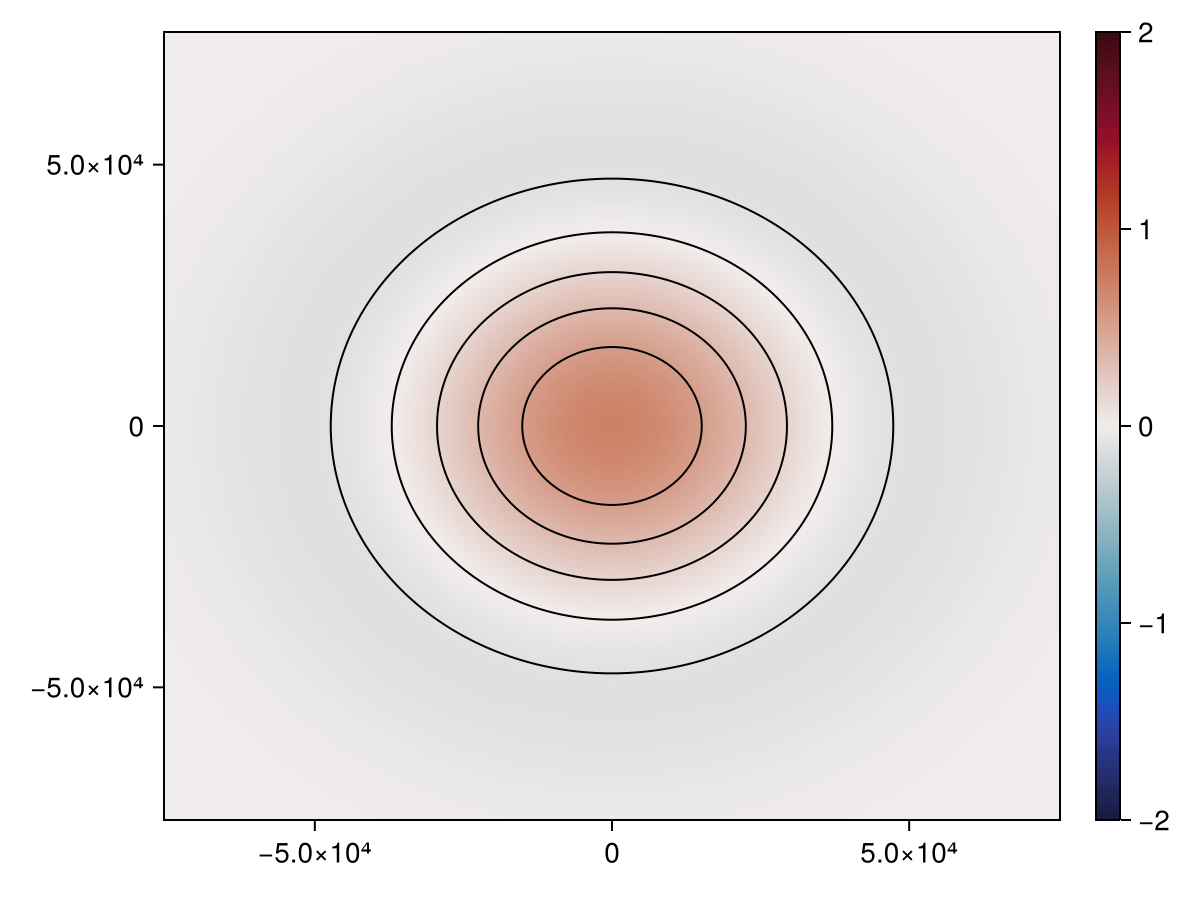

In [65]:
xs = range(-sp.L/2, sp.L/2, 200)
ys = range(-sp.L/2, sp.L/2, 200)
zs = range(-sp.H, 0, 200)
fig = Figure()
ax = Axis(fig[1, 1])

∂₁(a) = (x, y, z)->(a(x+5e-9, y, z) - a(x-5e-9, y, z)) / 1e-8
∂₂(a) = (x, y, z)->(a(x, y+5e-9, z) - a(x, y-5e-9, z)) / 1e-8
∂₃(a) = (x, y, z)->(a(x, y, z+5e-9) - a(x, y, z-5e-9)) / 1e-8

ht = heatmap!(ax, xs, ys, (x, y)->(∂₁(base_state.v)(x, y, 0) - ∂₂(base_state.u)(x, y, 0))/sp.f; colormap=:balance, colorrange=(-2, 2))
contour!(ax, xs, ys, (x, y)->base_state.b(x, y, 0); color=:black)
Colorbar(fig[1, 2], ht)
fig

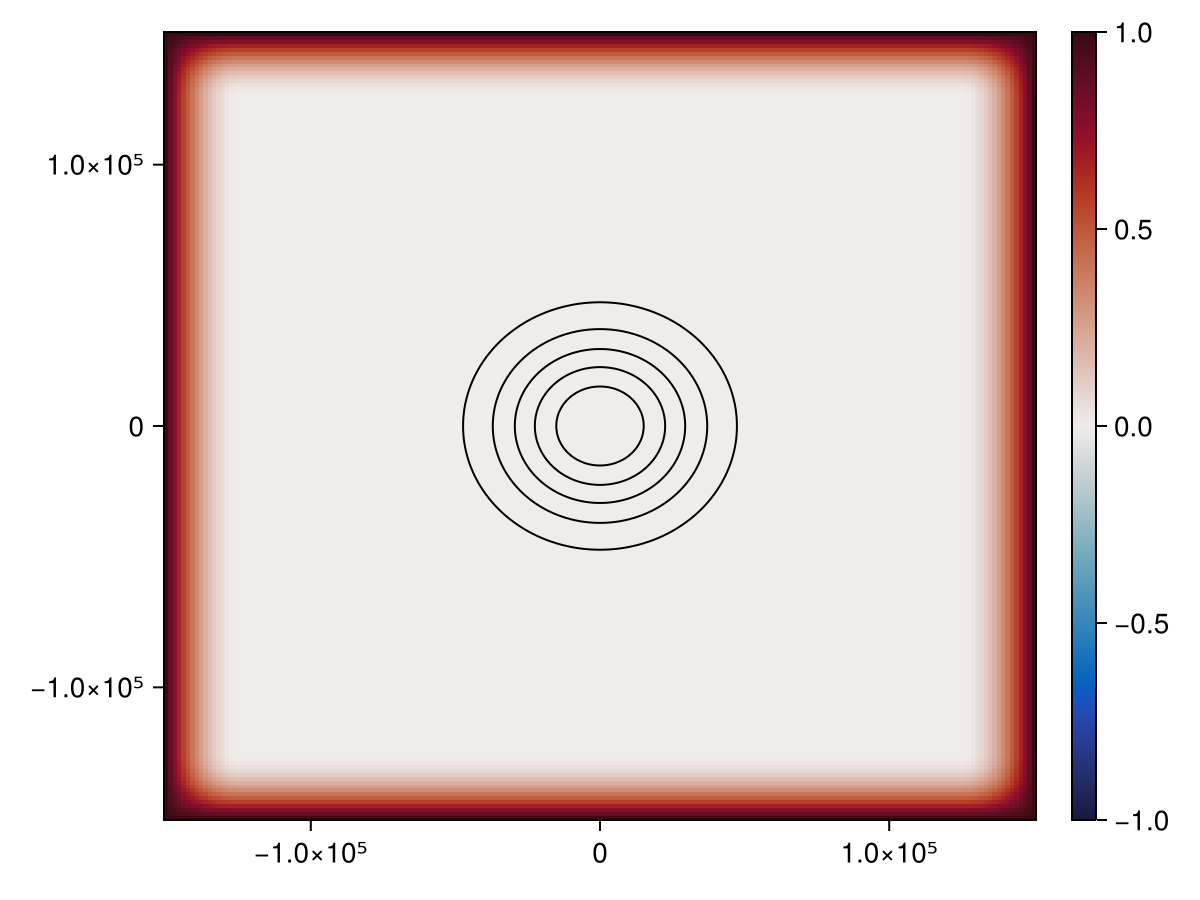

In [74]:
xs = range(-sp.L/2, sp.L/2, 200)
ys = range(-sp.L/2, sp.L/2, 200)
zs = range(-sp.H, 0, 200)
fig = Figure()
ax = Axis(fig[1, 1])

∂₁(a) = (x, y, z)->(a(x+5e-9, y, z) - a(x-5e-9, y, z)) / 1e-8
∂₂(a) = (x, y, z)->(a(x, y+5e-9, z) - a(x, y-5e-9, z)) / 1e-8
∂₃(a) = (x, y, z)->(a(x, y, z+5e-9) - a(x, y, z-5e-9)) / 1e-8

ht = heatmap!(ax, xs, ys, (x, y)->σ(x, y, 0)/sp.damping_rate; colormap=:balance, colorrange=(-1, 1))
contour!(ax, xs, ys, (x, y)->base_state.b(x, y, 0); color=:black)
Colorbar(fig[1, 2], ht)
fig

In [68]:
Δx = xs[2] - xs[1]
Δz = zs[2] - zs[1]
Ri_min = minimum([2Δz * (base_state.b(r, z+Δz) - base_state.b(r, z-Δz))/(v(r, z+Δz) - v(r, z-Δz))^2 for r in xs, z in zs])
Ro_max = maximum([(base_state.v(r+Δx, z) - base_state.v(r-Δx, z))/(2Δx * f) for r in xs, z in zs])
Ro_min = minimum([(base_state.v(r+Δx, z) - base_state.v(r-Δx, z))/(2Δx * f) for r in xs, z in zs])

LoadError: MethodError: no method matching (::var"#b₀#121"{var"#b#117"{Int64, Int64, Float64, Float64, var"#h#115", var"#g′#114"}})(::Float64, ::Float64)
[0mClosest candidates are:
[0m  (::var"#b₀#121")(::Any, ::Any, [91m::Any[39m) at /gpfs/fs1/home/n/ngrisoua/atkin163/Project/src-vortices/base_state.jl:30

In [75]:
a = (; one=1, two=2)
b = (; a.one)

(one = 1,)

In [194]:
ζs = [(∂₁(base_state.v)(x, y, 0) - ∂₂(base_state.u)(x, y, 0))/sp.f for x in xs, y in ys];
maximum(ζs)
#minimum(ζs)
Ris = [∂₃(base_state.b)(x, 0, z) / ∂₃(base_state.v)(x, 0, z)^2 for x in xs, z in zs];
minimum(abs.(Ris))

360430.1966872449

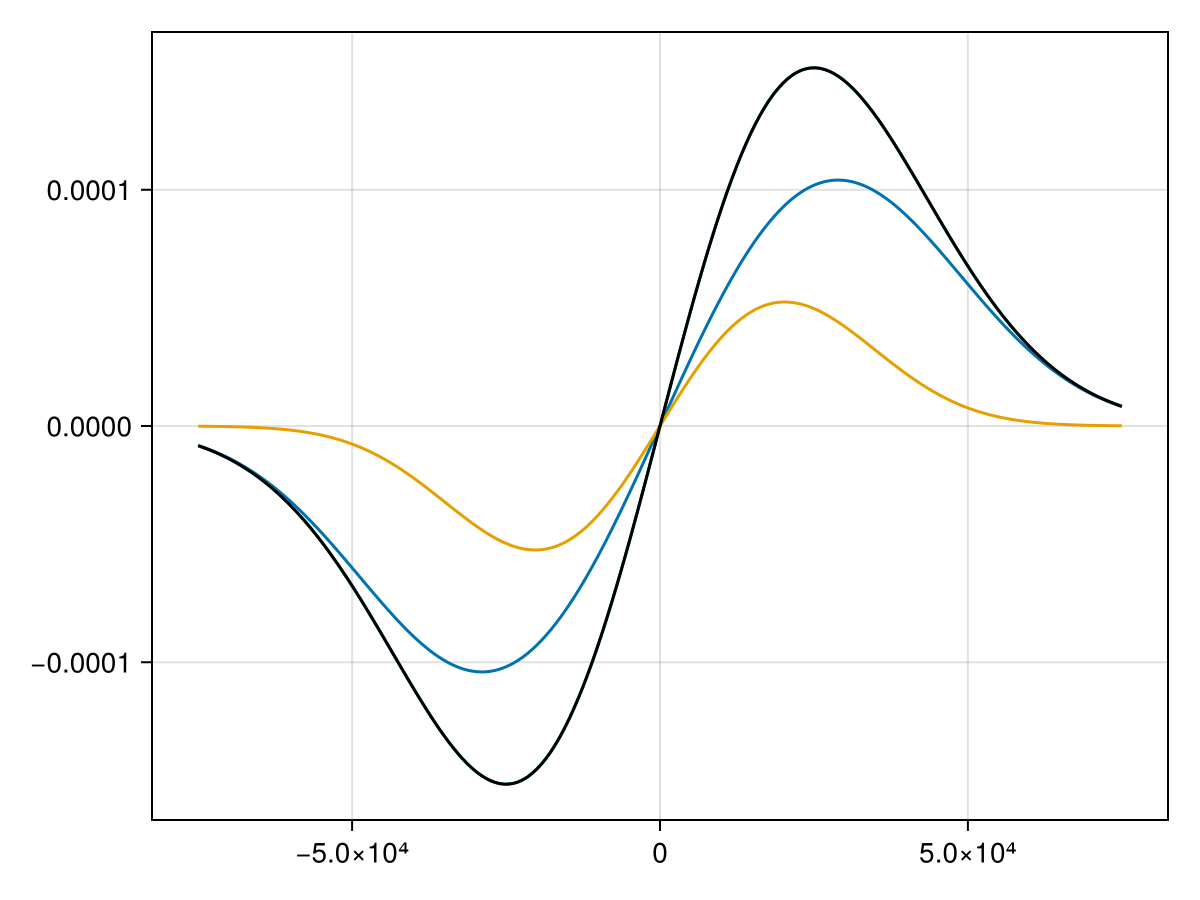

In [170]:
fig = Figure()
ax = Axis(fig[1, 1])

∂₃fv(r) = ∂₃(base_state.v)(r, 0, 0)*sp.f
∂₁b(r) = ∂₁(base_state.b)(r, 0, 0)
∂₃ωv(r) = 2*∂₃(base_state.v)(r, 0, 0)*base_state.v(r, 0, 0)/r

∂zv_line = lines!(ax, xs, ∂₃fv)
∂zωv_line = lines!(ax, xs, ∂₃ωv)
∂xb_line = lines!(ax, xs, ∂₁b)

sum_line = lines!(ax, xs, r->∂₃fv(r) + ∂₃ωv(r); color=:black)




fig

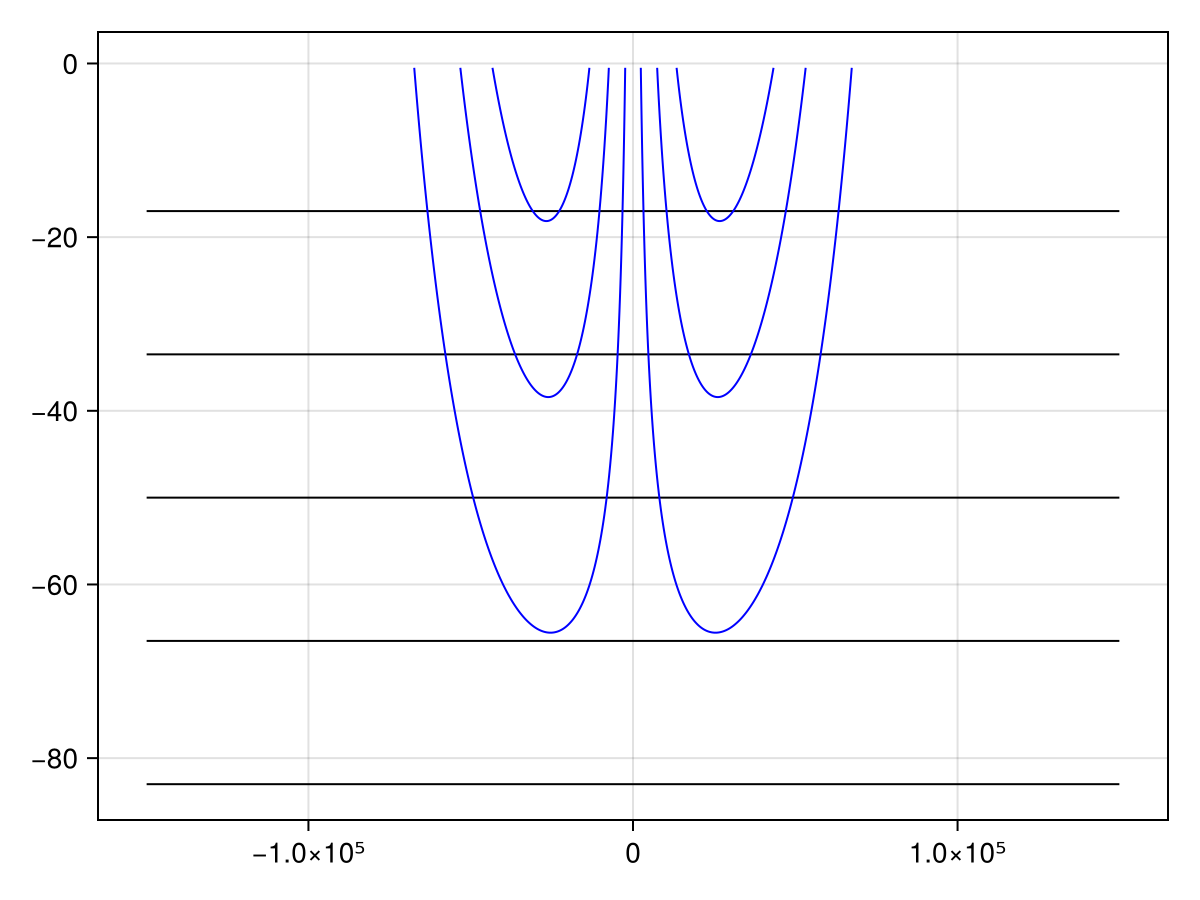

In [116]:
fig = Figure()
ax = Axis(fig[1, 1])
contour!(ax, xs, zs, (x, z)->base_state.b(x, 0, z); color=:black)
contour!(ax, xs, zs, (x, z)->base_state.v(x, 0, z); color=:blue, levels=6)
fig